In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
train_df = pd.read_csv("tweets_train.csv")                        #import traning dataset

In [3]:
test_df = pd.read_csv("tweets_test.csv")                          #import test dataset

In [4]:
print('Shape :',train_df.shape)                                   #shape of dataset(no. of rows and no. of columns)
print (train_df.head())

Shape : (7613, 5)
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [5]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [6]:
test_df.describe()                                            #description of complete traning dataset

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [7]:
train_df.isna().sum()                                           # no. of null records in each column of training dataset

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
test_df.isna().sum()                                            # no. of null records in each column of test dataset

id             0
keyword       26
location    1105
text           0
dtype: int64

In [9]:
train_df.loc[train_df['text'].str.contains('disaster', na=False, case=False)].target.value_counts()

1    102
0     40
Name: target, dtype: int64

In [10]:
train_df['text_length'] = train_df['text'].apply(lambda x : len(x))
train_df.head()

,id,keyword,location,text,target,text_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [11]:
train_df.text_length.describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_length, dtype: float64

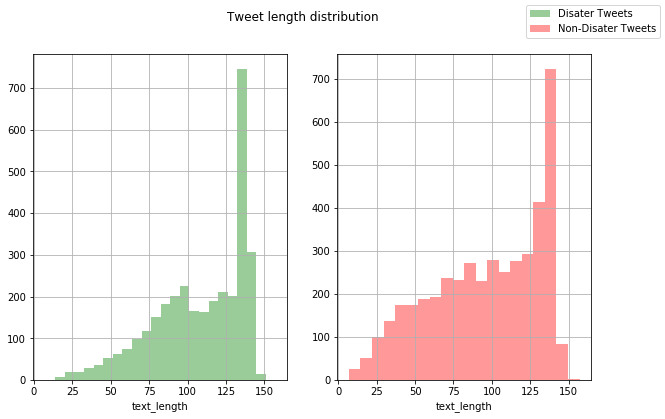

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize=(10,6))
sns.distplot(train_df[(train_df['target'] == 1)]['text_length'], ax=ax1, kde=False, color='green',label='Disater Tweets')
sns.distplot(train_df[(train_df['target'] == 0)]['text_length'],ax=ax2, kde=False, color='red',label='Non-Disater Tweets');
f.suptitle('Tweet length distribution')
f.legend(loc='upper right')
ax1.grid()
ax2.grid()
plt.show()

In [13]:
train_df[train_df['target']==1]['text'][10:20]

10          Three people died from the heat wave so far
11    Haha South Tampa is getting flooded hah- WAIT ...
12    #raining #flooding #Florida #TampaBay #Tampa 1...
13              #Flood in Bago Myanmar #We arrived Bago
14    Damage to school bus on 80 in multi car crash ...
31    @bbcmtd Wholesale Markets ablaze http://t.co/l...
33    #AFRICANBAZE: Breaking news:Nigeria flag set a...
37    INEC Office in Abia Set Ablaze - http://t.co/3...
38    Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...
46    How the West was burned: Thousands of wildfire...
Name: text, dtype: object

In [14]:
train_df[train_df['target']==0]['text'][10:20]

25                       No way...I can't eat that shit
26                                Was in NYC last week!
27                                   Love my girlfriend
28                                            Cooool :)
29                                   Do you like pasta?
30                                             The end!
32    We always try to bring the heavy. #metal #RT h...
34                   Crying out for more! Set me ablaze
35    On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
36    @PhDSquares #mufc they've built so much hype a...
Name: text, dtype: object

In [15]:
test_df['text'][:10] 

0                   Just happened a terrible car crash
1    Heard about #earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             Apocalypse lighting. #Spokane #wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
5                   We're shaking...It's an earthquake
6    They'd probably still show more life than Arse...
7                                    Hey! How are you?
8                                     What a nice hat?
9                                            Fuck off!
Name: text, dtype: object

In [16]:
# Now we need to clean text column of training and test dataset. Lets make function for cleaning data.
# Remove remove square brackets,links,punctuation and words containing numbers.
# Convert text into lower case.
def clean_text(text):

    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [17]:
# apply text cleaning function to training an test datasets.
train=train_df.copy()
test=test_df.copy()
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

In [18]:
print(train)                                    # After cleaning train dataset

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  text_length  
0     our deeds are the reason of this earthquake ma...       1           69  
1                 forest fire near la ronge sask canada       1           38  
2     all residents asked to shelter in place are be...       1          133  
3      people receive wildfires evacuation orders in...       1           65  
4     just got sent this photo from ruby alaska as s...       1           88  
...                                                 ...     ...          ...  
7608  two giant cranes holding a bridge collapse int...       

In [19]:
print(test)                                           # After cleaning train dataset

         id keyword location  \
0         0     NaN      NaN   
1         2     NaN      NaN   
2         3     NaN      NaN   
3         9     NaN      NaN   
4        11     NaN      NaN   
...     ...     ...      ...   
3258  10861     NaN      NaN   
3259  10865     NaN      NaN   
3260  10868     NaN      NaN   
3261  10874     NaN      NaN   
3262  10875     NaN      NaN   

                                                   text  
0                    just happened a terrible car crash  
1     heard about earthquake is different cities sta...  
2     there is a forest fire at spot pond geese are ...  
3                 apocalypse lighting spokane wildfires  
4           typhoon soudelor kills  in china and taiwan  
...                                                 ...  
3258  earthquake safety los angeles ûò safety faste...  
3259  storm in ri worse than last hurricane my  hard...  
3260                  green line derailment in chicago   
3261          meg issues hazardous 

In [20]:
# Lets Tokenize the training and the test dataset copies with RegEx tokenizer

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))

In [21]:
train['text'].head()                                           # After tokenizing training dataset.

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [22]:
# Get all stopwords together
stop = stopwords.words("english")
item=['amp']
stop.extend(item)

In [23]:
#Remove stopwords from each record of training and test dataset.
train['text']=train['text'].apply(lambda x: [item for item in x if item not in stop])
test['text']=test['text'].apply(lambda x: [item for item in x if item not in stop])

In [24]:
train['text'].head()                                             # After removing stopwords from training dataset.

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

In [25]:
test['text'].head()                                              # After removing stopwords from training dataset.

0                     [happened, terrible, car, crash]
1    [heard, earthquake, different, cities, stay, s...
2    [forest, fire, spot, pond, geese, fleeing, acr...
3           [apocalypse, lighting, spokane, wildfires]
4            [typhoon, soudelor, kills, china, taiwan]
Name: text, dtype: object

In [26]:
# Instantiating lemmatizer 
lemmatizer = WordNetLemmatizer()

In [27]:
# lemmatization of training dataset
lemmatize_words=[]
for i in range (len(train['text'])):
    word=''
    for j in range(len(train['text'][i])):
        lemm_word=lemmatizer.lemmatize(train['text'][i][j])     # lemmatize
        
        word=word + ' '+lemm_word                               # joining tokens into sentence    
    lemmatize_words.append(word)                                # store in list

In [28]:
train['text']=lemmatize_words                                   # Assign lemmatize words to train['text']

In [29]:
train.head()

,id,keyword,location,text,target,text_length
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1,69
1,4,NaN,NaN,forest fire near la ronge sask canada,1,38
2,5,NaN,NaN,resident asked shelter place notified officer...,1,133
3,6,NaN,NaN,people receive wildfire evacuation order cali...,1,65
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pou...,1,88


In [30]:
# Lemmatization of test dataset
lemmatize_words1=[]
for i in range (len(test['text'])):
    word=''
    for j in range(len(test['text'][i])):
        lemm_word=lemmatizer.lemmatize(test['text'][i][j])          # lemmatize
        
        word=word + ' '+lemm_word                                   # joining tokens into sentence    
    lemmatize_words1.append(word)                                   # store in list

In [31]:
test['text']=lemmatize_words1

In [32]:
# Vectorize the text using CountVectorizer
count_vectorizer = CountVectorizer()
train_cv = count_vectorizer.fit_transform(train['text'])
test_cv = count_vectorizer.transform(test["text"])

# Keeping only non-zero elements to preserve space 
print(train_cv[0].todense())

[[0 0 0 ... 0 0 0]]


In [33]:
#Split the CountVector vectorized data into train and test datasets for model training and testing
X_train_cv, X_test_cv, y_train_cv, y_test_cv =train_test_split(train_cv,train_df.target,test_size=0.2,random_state=2020)

In [34]:
# Function to predict target in training and testing data.
# Print accuracy of model
def predict(model,X_train,y_train,X_test,y_test):
    
    clf = model
    clf.fit(X_train, y_train)
    predictions=clf.predict(X_test)
    confusion_matrix(y_test,predictions)
    print(classification_report(y_test,predictions))
    print('-'*50)
    print("{}" .format(model))
    print('-'*50)
    print('Accuracy of classifier on training set:{}%'.format(round(clf.score(X_train, y_train)*100)))
    print('-'*50)
    print('Accuracy of classifier on test set:{}%' .format(round(accuracy_score(y_test,predictions)*100)))
    print('-'*50)


In [35]:
# Create a list of the regression models to be used
models=[LogisticRegression(C=1.0),SVC(),MultinomialNB(),DecisionTreeClassifier(),
        KNeighborsClassifier(n_neighbors=5),RandomForestClassifier()]

In [36]:
# Loop through the list of models and use function to trian and make predictions
for model in models:
    predict(model,X_train_cv, y_train_cv,X_test_cv,y_test_cv)


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.79      0.88      0.83       849
           1       0.82      0.70      0.76       674

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.80      0.80      0.80      1523

--------------------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
--------------------------------------------------
Accuracy of classifier on training set:96.0%
--------------------------------------------------
Accuracy of classifier on test set:80.0%
--------------------------------------------------


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.56      1.00      0.72       849
           1       0.00      0.00      0.00       674

    accuracy                           0.56      1523
   macro avg       0.28      0.50      0.36      1523
weighted avg       0.31      0.56      0.40      1523

--------------------------------------------------
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
--------------------------------------------------
Accuracy of classifier on training set:57.0%
--------------------------------------------------
Accuracy of classifier on test set:56.0%
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       849
           1       0.79      0.7

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.75      0.90      0.82       849
           1       0.83      0.63      0.71       674

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.78      0.78      0.77      1523

--------------------------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
--------------------------------------------------
Accuracy of classifier on training set:97.0%
------------------------------------

In [37]:
#From all the models above, logistic regression seems to be the best fitted model.
# Fitting 'LogisticRegression()' with CountVectorizer() fit dataset

clf_logreg = LogisticRegression(C=1.0)
clf_logreg.fit(X_train_cv, y_train_cv)
pred=clf_logreg.predict(X_test_cv)
confusion_matrix(y_test_cv,pred)
print(classification_report(y_test_cv,pred))
print('Accuracy of classifier on training set:{}%'.format(round(clf_logreg.score(X_train_cv, y_train_cv)*100)))
print('Accuracy of classifier on test set:{}%' .format(round(accuracy_score(y_test_cv,pred)*100)))


              precision    recall  f1-score   support

           0       0.79      0.88      0.83       849
           1       0.82      0.70      0.76       674

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.80      0.80      0.80      1523

Accuracy of classifier on training set:96.0%
Accuracy of classifier on test set:80.0%


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [38]:
clf_logreg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
test

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different city stay safe eve...
2,3,NaN,NaN,forest fire spot pond goose fleeing across st...
3,9,NaN,NaN,apocalypse lighting spokane wildfire
4,11,NaN,NaN,typhoon soudelor kill china taiwan
...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles ûò safety faste...
3259,10865,NaN,NaN,storm ri worse last hurricane hardest hit yar...
3260,10868,NaN,NaN,green line derailment chicago
3261,10874,NaN,NaN,meg issue hazardous weather outlook hwo


In [40]:
# Lets fit the test data with Countvectorizer() method to vectroize the data
test_vector = count_vectorizer.transform(test["text"])

In [41]:
test_vector

<3263x15127 sparse matrix of type '<class 'numpy.int64'>'
	with 24093 stored elements in Compressed Sparse Row format>

In [42]:
prediction=clf_logreg.predict(test_vector)

In [43]:
prediction

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [44]:
sub_file = pd.DataFrame()

In [45]:
sub_file['Id'] = test.id
sub_file['target'] = prediction

In [46]:
sub_file

,Id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [47]:
sub_file.loc[ :].to_csv('subm1.csv',index=False)

In [48]:
# function to create download link for prediction file
import base64  
from IPython.display import HTML

def create_download_link( submission1, title = "Download CSV file", filename = "data.csv"):  
    csv = submission1.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(sub_file)